# Финальный проект
Добро пожаловать, в ноутбук!!!

В данном задании вам предстоит построить ML модель на таргете, где присутствует сильный дисбаланс классов.

*Обратите внимание на следующие поля:*

* `TARGET` - Наш таргет
* `OBSDATE` - Дата. Эта поле необходимо для фиксирования финальных метрик обученной модели.

Рекомендации по разбиению данных на подвыборки:
1. train и val получаем через train_test_split - можете произвольно подбирать test_size, но рекомендуем около 20%
2. test, то есть отложенную выборку, выделяем через OBSDATE >= 2023-11-01 - данное условие не подлежит изменению

Максимальное количество баллов: 100 (основных) + 20 (дополнительные)

final_mark = np.max(your_mark, 100)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Для разделения данных
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Для кодирования категориальных признаков (Target Encoding)
from category_encoders import CatBoostEncoder

# Для балансировки (oversampling)
from imblearn.over_sampling import ADASYN

# Бустинг (пример: LightGBM)
import lightgbm as lgb

# Метрики
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# SHAP для важности признаков
import shap

In [28]:
import pandas as pd
df = pd.read_parquet("/Users/maximbortnik/Downloads/MIPT_project/MIPT_data_prod.parquet")
df.describe

<bound method NDFrame.describe of         TARGET    OBSDATE  col_0  col_1  col_2  col_3  col_4  col_5  col_6  \
464723       0 2023-07-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
706874       0 2023-02-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
139927       0 2023-03-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
267979       0 2023-09-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
479451       0 2023-05-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...        ...    ...    ...    ...    ...    ...    ...    ...   
135780       0 2023-09-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
693921       0 2023-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
171498       0 2023-05-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
751597       0 2023-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
103628       0 2023-03-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        col_7  ...  col_226  

## Preprocessing
### Обработка пропущенных значений (10 баллов)
### Обработка категориальных признаков (10 балллов)

**Проверьте данные на константные фичи и фичи, имеющие большое количество пропущенных значений.**

`Если переменная имеет более 80% пропущенных значений, то удалите ее`.

**Заполните пропуски отдельным значением для категориальных и числовых признаков.**

**`Подсказка`: для распознавания категориальных признаков попробуйте посчитать количество уникальных значений фичи.**

In [29]:
pct_threshold = 0.8
nan_ratio = df.isna().mean()
to_drop_cols = nan_ratio[nan_ratio > pct_threshold].index
df.drop(columns=to_drop_cols, inplace=True)

# 2.2 Удаляем константные фичи
nunique = df.nunique(dropna=False)
const_cols = nunique[nunique <= 1].index
df.drop(columns=const_cols, inplace=True)

## Разделите данные на train, val и test (5 баллов)

1. train для обучения

2. val для промежуточной оценки метрик

3. test - отложенная выборка для финальной оценки метрик

Для test строго используйте условие `OBSDATE >= "2023-11-01"`

In [30]:
test_mask = df['OBSDATE'] >= "2023-11-01"
df_test = df[test_mask].copy()
df_rest = df[~test_mask].copy()

# Делим df_rest на train и val
X_rest = df_rest.drop(columns=['TARGET', 'OBSDATE'])
y_rest = df_rest['TARGET']

X_train, X_val, y_train, y_val = train_test_split(
    X_rest,
    y_rest,
    test_size=0.2,
    stratify=y_rest,
    random_state=42
)

X_test = df_test.drop(columns=['TARGET', 'OBSDATE'])
y_test = df_test['TARGET']

In [31]:
def define_cat_num_columns(df_train, threshold_cat=20):
    """Определяем, какие колонки будем считать категориальными/числовыми"""
    cat_cols_ = []
    num_cols_ = []
    for col in df_train.columns:
        # Если мало уникальных значений ИЛИ dtype=object -> cat
        # Исключаем possible target, etc.
        if df_train[col].dtype == 'object' or df_train[col].nunique() < threshold_cat:
            cat_cols_.append(col)
        else:
            num_cols_.append(col)
    return cat_cols_, num_cols_

cat_cols, num_cols = define_cat_num_columns(X_train)


In [32]:
# 4.2 Заполнение пропусков
#     - Числовые: учим медians или -999 ТОЛЬКО на train, применяем к val/test
#     - Категориальные: учим fill_value "MISSING"

# Сделаем словари подстановок
num_medians = {}
for col in num_cols:
    # Считаем медиану на train
    median_val = X_train[col].median()
    num_medians[col] = median_val

# Для категориальных - "MISSING"
cat_fill_value = "MISSING"

# Функция для apply
def fill_missing_values(df_, cat_cols_, num_cols_, num_medians_dict, cat_value="MISSING"):
    df_filled = df_.copy()
    for c in num_cols_:
        df_filled[c] = df_filled[c].fillna(num_medians_dict[c])
    for c in cat_cols_:
        df_filled[c] = df_filled[c].fillna(cat_value)
    return df_filled

# Применяем
X_train_filled = fill_missing_values(X_train, cat_cols, num_cols, num_medians)
X_val_filled   = fill_missing_values(X_val, cat_cols, num_cols, num_medians)
X_test_filled  = fill_missing_values(X_test, cat_cols, num_cols, num_medians)

**Закодируйте категориальные признаки через target encoding**

`Рекомендуем к использованию библиотеку category_encoders, а в ней класс cat_boost.CatBoostEncoder()`

In [33]:
#fit только на train, transform на val, test
encoder = CatBoostEncoder(cols=cat_cols, random_state=42)
encoder.fit(X_train_filled, y_train)

X_train_enc = encoder.transform(X_train_filled)
X_val_enc   = encoder.transform(X_val_filled)
X_test_enc  = encoder.transform(X_test_filled)


## Feature selection (15 баллов)
Отберите признаки для обучения модели.

Попробуйте отбирать разное количество N лучших признаков. 
Для отбора N лучших признаков можно попробовать несколько подходов: однофакторный анализ, мультиколлинеартность признаков, permutation importance и т.д.
Будет интересно найти оптимальное количество фичей (построить зависимость метрики качества от количества фичей), чтобы не использовать лишние фичи при обучении.

Подумайте:
Cтоит ли использовать для обучения признак, который слишком хорошо предсказывает TARGET?

**Анализ корреляций, feature selection**

In [ ]:
# Смотрим корреляцию с TARGET (только для числовых фич), но теперь у нас в train_enc всё числовое (после target encoding), поэтому мы можем посмотреть corr c y_train
train_enc_with_y = X_train_enc.copy()
train_enc_with_y['TARGET'] = y_train.values

corrs = train_enc_with_y.corr()['TARGET'].drop('TARGET')
# Порог корреляции для удаления = 0,7
too_correlated = corrs[abs(corrs) > 0.7].index
print("Слишком высокая корр с TARGET (>0.7):", list(too_correlated))

Слишком высокая корр с TARGET (>0.7): ['col_234']


In [35]:
# Удалим эту фичу из train_enc/val_enc/test_enc
X_train_enc.drop(columns=too_correlated, inplace=True, errors='ignore')
X_val_enc.drop(columns=too_correlated, inplace=True, errors='ignore')
X_test_enc.drop(columns=too_correlated, inplace=True, errors='ignore')

In [36]:
#LightGBM
temp_model = lgb.LGBMClassifier(random_state=42, n_estimators=50)
temp_model.fit(X_train_enc, y_train)

feat_imp_df = pd.DataFrame({
    'feature': X_train_enc.columns,
    'importance': temp_model.feature_importances_
}).sort_values('importance', ascending=False)

TOP_N = 30 if feat_imp_df.shape[0] > 30 else feat_imp_df.shape[0]
selected_features = feat_imp_df['feature'].head(TOP_N).tolist()

X_train_sel = X_train_enc[selected_features]
X_val_sel   = X_val_enc[selected_features]
X_test_sel  = X_test_enc[selected_features]

[LightGBM] [Info] Number of positive: 985, number of negative: 51118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18385
[LightGBM] [Info] Number of data points in the train set: 52103, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018905 -> initscore=-3.949250
[LightGBM] [Info] Start training from score -3.949250


## Сэмплирование (20 баллов)

Примените к обучающей подвыборке оверсэмплинг (метод решения проблемы дисбаланса классов)

Рекомендуем воспользоваться `ADASYN` из imblearn.over_sampling, можете использовать другие методы на ваше усмотрение

In [37]:
adasyn = ADASYN(random_state=42)
X_train_sel_over, y_train_over = adasyn.fit_resample(X_train_sel, y_train)


## Построение финальной модели, подсчет метрик и подбор гиперпараметров (15 + 10 баллов)

**Постройте бустинг (CatBoost, XGBoost, LightGBM) (10 баллов)**

**Оцените качество модели на (train, val, test) (5 баллов)**

**Подберите 4 гиперпараметра, используйте кросс-валидацию [Задание на доп баллы] (10 баллов)**

In [38]:
#Построение финальной модели
final_model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31
)
final_model.fit(X_train_sel_over, y_train_over)

y_train_pred_proba = final_model.predict_proba(X_train_sel_over)[:,1]
y_val_pred_proba   = final_model.predict_proba(X_val_sel)[:,1]
if len(X_test_sel) > 0:
    y_test_pred_proba  = final_model.predict_proba(X_test_sel)[:,1]
else:
    y_test_pred_proba  = None

[LightGBM] [Info] Number of positive: 50959, number of negative: 51118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7617
[LightGBM] [Info] Number of data points in the train set: 102077, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499221 -> initscore=-0.003115
[LightGBM] [Info] Start training from score -0.003115


In [39]:
# Метрика ROC-AUC
train_roc_auc = roc_auc_score(y_train_over, y_train_pred_proba)
val_roc_auc   = roc_auc_score(y_val, y_val_pred_proba)
test_roc_auc  = None
if y_test_pred_proba is not None and len(y_test) > 0:
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("=== FINAL MODEL METRICS ===")
print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Val   ROC-AUC: {val_roc_auc:.4f}")
if test_roc_auc is not None:
    print(f"Test  ROC-AUC: {test_roc_auc:.4f}")

# Classification Report (val)
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
print("\nClassification Report (Val):")
print(classification_report(y_val, y_val_pred))

if test_roc_auc is not None:
    y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))


=== FINAL MODEL METRICS ===
Train ROC-AUC: 0.9980
Val   ROC-AUC: 0.6992
Test  ROC-AUC: 0.6765

Classification Report (Val):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12780
           1       0.08      0.02      0.03       246

    accuracy                           0.98     13026
   macro avg       0.53      0.51      0.51     13026
weighted avg       0.96      0.98      0.97     13026


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     34521
           1       0.03      0.01      0.02       350

    accuracy                           0.99     34871
   macro avg       0.51      0.50      0.50     34871
weighted avg       0.98      0.99      0.98     34871



In [ ]:
# Подбор гиперпараметров 
param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.02, 0.05],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 50, 100],
    'scale_pos_weight': [1, 2, 5, 10], 
    'reg_alpha': [0, 1, 3, 5],
    'reg_lambda': [0, 1, 3, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}


base_model = lgb.LGBMClassifier(random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_sel_over, y_train_over)
print("\nBest Params:", random_search.best_params_)
print("Best CV Score (roc_auc):", random_search.best_score_)

best_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_model.fit(X_train_sel_over, y_train_over)

y_val_pred_proba_best = best_model.predict_proba(X_val_sel)[:,1]
val_roc_auc_best = roc_auc_score(y_val, y_val_pred_proba_best)
print(f"\nBEST MODEL VAL ROC-AUC: {val_roc_auc_best:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 33972, number of negative: 34079
[LightGBM] [Info] Number of positive: 33973, number of negative: 34079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7617
[LightGBM] [Info] Number of positive: 33972, number of negative: 34079
[LightGBM] [Info] Number of data points in the train set: 68051, number of used features: 30
[LightGBM] [Info] Number of positive: 33973, number of negative: 34078
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499214 -> initscore=-0.003145
[LightGBM] [Info] Start training from score -0.003145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

## Построение графиков (15 баллов)

Необходимо построить:

* Roc auc curve

* Precision recall curve

* Heatmap для матрицы ошибок 

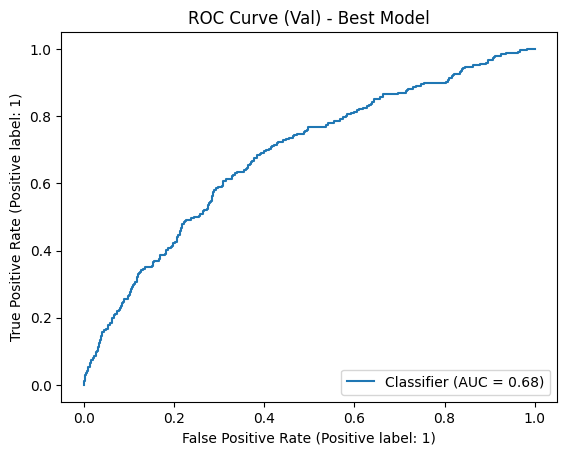

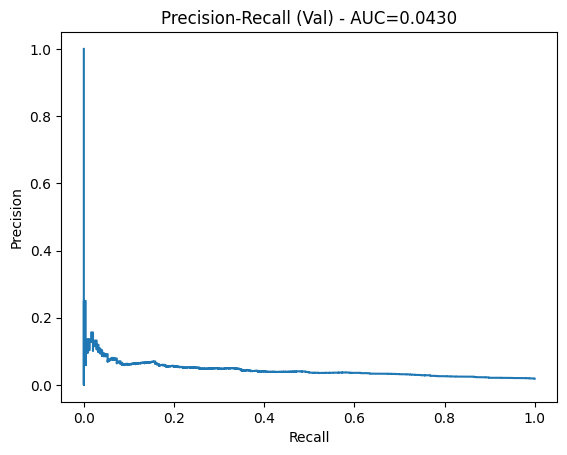

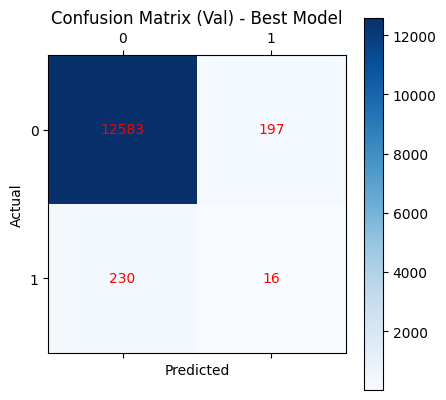

In [44]:
# ROC
RocCurveDisplay.from_predictions(y_val, y_val_pred_proba_best)
plt.title("ROC Curve (Val) - Best Model")
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_val, y_val_pred_proba_best)
pr_auc = auc(rec, prec)
disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()
plt.title(f"Precision-Recall (Val) - AUC={pr_auc:.4f}")
plt.show()

# Confusion Matrix
y_val_pred_best = (y_val_pred_proba_best >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_val_pred_best)
plt.matshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Val) - Best Model")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val_ij in np.ndenumerate(cm):
    plt.text(j, i, val_ij, ha='center', va='center', color='red')
plt.show()


## Выделите ключевые признаки (10 баллов)
При помощи библиотеки shap выделите 5 самых важных признаков при построении модели

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


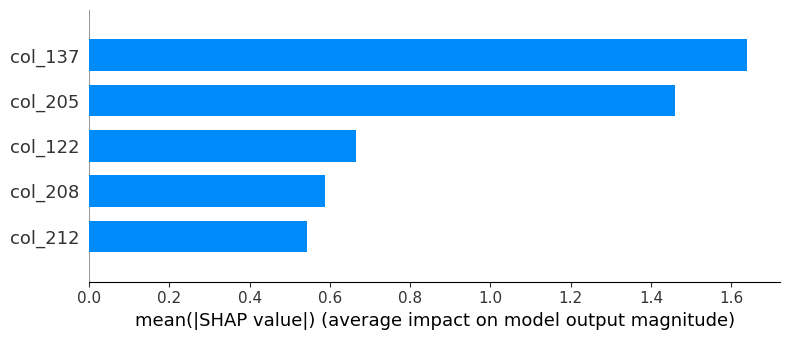

In [42]:
#SHAP (топ-5 признаков)
explainer = shap.TreeExplainer(best_model)
X_val_sample = X_val_sel.sample(min(200, len(X_val_sel)), random_state=42)

shap_values = explainer.shap_values(X_val_sample)

# Бар-чарт
shap.summary_plot(shap_values, X_val_sample, plot_type="bar", max_display=5)